# Demo 2: Espacio latente con un autoencoder

En Stable Diffusion, el gran truco es trabajar en el **espacio latente**, en lugar de hacerlo directamente sobre los píxeles.

Para entender qué significa esto, vamos a entrenar un **autoencoder** muy simple con MNIST:
- El **encoder** convierte una imagen en una representación comprimida (latente).
- El **decoder** reconstruye la imagen original a partir de esa representación.

Así veremos:
- Cómo una imagen puede "vivir" en un espacio más pequeño.
- Cómo desde ese espacio podemos volver a reconstruirla.


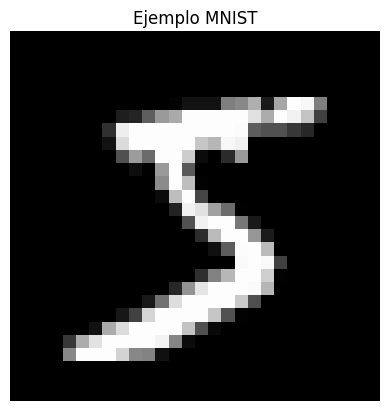

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# Cargar dataset MNIST
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

# Normalizar y reescalar
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

# Añadir canal (28x28 -> 28x28x1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

plt.imshow(x_train[0].squeeze(), cmap="gray")
plt.title("Ejemplo MNIST")
plt.axis("off")
plt.show()


## Definir el autoencoder

El autoencoder tiene dos partes:
- **Encoder**: reduce la imagen a un vector de pocas dimensiones (espacio latente).
- **Decoder**: toma ese vector y reconstruye la imagen original.

Este proceso es similar a lo que hace el VAE en Stable Diffusion.


In [3]:
# Dimensión del espacio latente
latent_dim = 16

# Encoder
encoder = models.Sequential([
    layers.Input(shape=(28,28,1)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(latent_dim, activation="relu")
])

# Decoder
decoder = models.Sequential([
    layers.Input(shape=(latent_dim,)),
    layers.Dense(64, activation="relu"),
    layers.Dense(28*28, activation="sigmoid"),
    layers.Reshape((28,28,1))
])

# Autoencoder completo
autoencoder = models.Sequential([encoder, decoder])
autoencoder.compile(optimizer="adam", loss="mse")

autoencoder.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 16)             │        51,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 28, 28, 1)      │        52,048 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,328 (403.62 KB)

 Trainable params: 103,328 (403.62 KB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento del autoencoder

El modelo aprenderá a "copiar" la entrada en la salida, pero en medio ha pasado por el espacio latente.

Es decir:
- Entrada: imagen de 28x28.
- Encoder: la reduce a un vector de 16 números.
- Decoder: desde esos 16 números, reconstruye la imagen.


In [4]:
history = autoencoder.fit(
    x_train, x_train,
    epochs=5,
    batch_size=256,
    validation_data=(x_test, x_test)
)


Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0678 - val_loss: 0.0416
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0362 - val_loss: 0.0312
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0291 - val_loss: 0.0264
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0256 - val_loss: 0.0243
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0242 - val_loss: 0.0232


## Visualización

Ahora podemos comparar:
- La imagen original.
- La reconstruida a partir del espacio latente.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


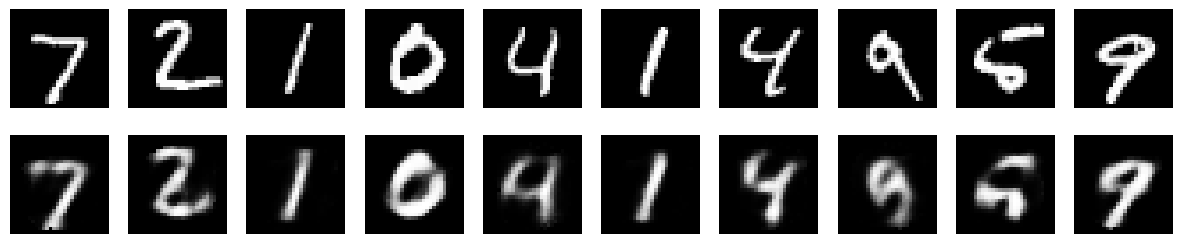

In [5]:
# Codificar y reconstruir algunas imágenes
latents = encoder.predict(x_test[:10])
recons = autoencoder.predict(x_test[:10])

fig, axs = plt.subplots(2, 10, figsize=(15,3))
for i in range(10):
    axs[0,i].imshow(x_test[i].squeeze(), cmap="gray")
    axs[0,i].axis("off")
    axs[1,i].imshow(recons[i].squeeze(), cmap="gray")
    axs[1,i].axis("off")
axs[0,0].set_ylabel("Original")
axs[1,0].set_ylabel("Reconstruida")
plt.show()
